## Image Classification: Leaf Classification

This notebook uses data from Kaggle's competition, Leaf Classification, to use binary leaf images and extracted features, including shape, margin & texture, to predict 99 species of plants. 

##### Dataset:
per Kaggle -
The dataset contains 1,584 images of leaf specimens (16 samples each of 99 species) which have been converted to binary black leaves against white backgrounds. Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

##### Objective:
to predict the probability of a binary leaf image and extracted features belonging to each class species.

##### Process:
Various models will be compared. The best performing model will be used to make predictions on a test set. 


##### Steps:

1. Import Libraries
2. Download & Read Kaggle date set, leaf-classification
3. Explore Data
4. Build & Evaluate Models (Multiclass Logistic Regression, Multiclass Random Forest, KNearest Neighbors, Multiclass Gradient Boosting)
5. Predict Test Set

Data Source: https://www.kaggle.com/competitions/leaf-classification/data

Citation:
Julia Elliott, Meghan O'Connell, Will Cukierski. (2016). Leaf Classification. Kaggle. https://kaggle.com/competitions/leaf-classification

### Import Libraries

In [41]:
#Data processing
import numpy as np
import pandas as pd
from statistics import mean

import os, glob, cv2, re
#!pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

#Modelling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import loguniform
from scipy.stats import randint as sp_randInt
from sklearn.metrics import accuracy_score


In [2]:
!mkdir ~/.kaggle
!echo '{"username":"sherylmichael","key":"ee2137bd8d95cc0d1f29d42dc871a87d"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/sherilyn/.kaggle: File exists


### Download & Read Kaggle date set, dogs-vs-cats-redux-kernels-edition

In [13]:
#download Kaggle data set
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

api = KaggleApi()
api.authenticate()

api.competition_download_files('leaf-classification')

In [14]:
zf = ZipFile('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/leaf-classification.zip')
zf.extractall('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data')
zf.close()

In [17]:
files = glob.glob('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/*.zip')
for file in files:
    print('Unzipping:',file)
    with ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data')

Unzipping: /Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/images.zip
Unzipping: /Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/test.csv.zip
Unzipping: /Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/train.csv.zip
Unzipping: /Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/sample_submission.csv.zip


In [3]:
#create directory of images (list)
train = pd.read_csv('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/train.csv')
test = pd.read_csv('/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/test.csv')

In [4]:
print('train.shape: ', train.shape, 'test.shape: ', test.shape)
print('train - num unique species: ',train['species'].nunique())
print('train.isnull().sum().sum(): ', train.isnull().sum().sum())
print('test.isnull().sum().sum(): ', test.isnull().sum().sum())

train.shape:  (990, 194) test.shape:  (594, 193)
train - num unique species:  99
train.isnull().sum().sum():  0
test.isnull().sum().sum():  0


In [20]:
print('train.head(): \n', train.head())
print('test.head()): \n', test.head())

train.head(): 
    id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0  ...   0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0  ...   0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        

The training set, train, has 990 binary leaf images and extracted features. train has an id column, a species column and 192 features used to predict 99 species of plants and no missing values.

The test set, test, has 594 binary leafimages and extracyed features. test has 192 features and no missing values.

### Explore Data

#### Visualizing Random Images

['1097.jpg' '165.jpg' '599.jpg']


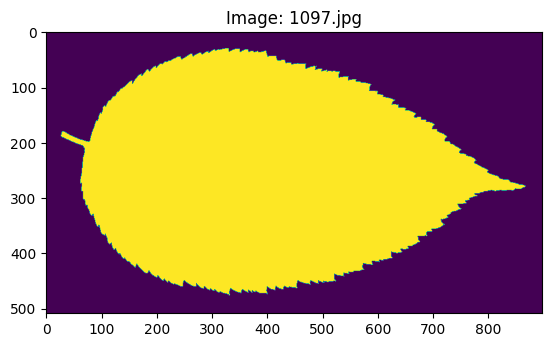

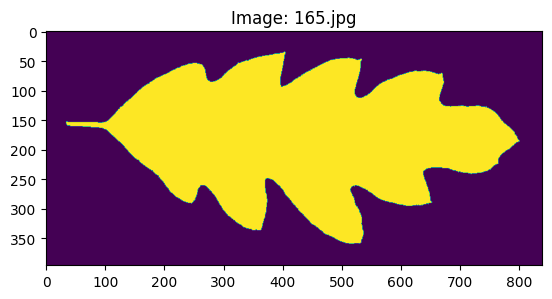

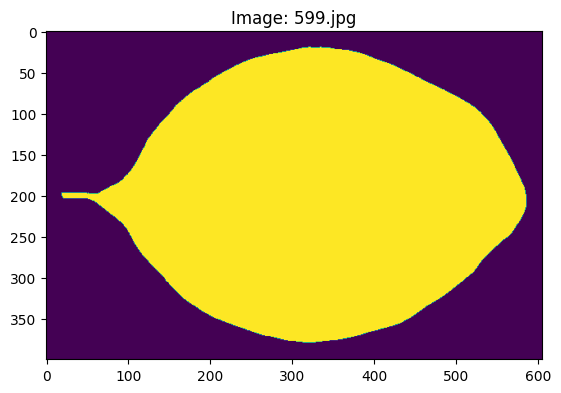

In [171]:
path = '/Users/sherilyn/ds_jungle/computer_vision/classification/multiclass/leaf_classification/data/images/'  
images = os.listdir(path) 
random_images = np.random.choice(images, 3)
print(random_images)

for i in random_images:
    image = Image.open(path + '/' + i) 
    plt.title('Image: ' + str(i))
    plt.imshow(image)
    plt.show()

#### Distribution of data

In [172]:
Counter(train['species'])

Counter({'Acer_Opalus': 10,
         'Pterocarya_Stenoptera': 10,
         'Quercus_Hartwissiana': 10,
         'Tilia_Tomentosa': 10,
         'Quercus_Variabilis': 10,
         'Magnolia_Salicifolia': 10,
         'Quercus_Canariensis': 10,
         'Quercus_Rubra': 10,
         'Quercus_Brantii': 10,
         'Salix_Fragilis': 10,
         'Zelkova_Serrata': 10,
         'Betula_Austrosinensis': 10,
         'Quercus_Pontica': 10,
         'Quercus_Afares': 10,
         'Quercus_Coccifera': 10,
         'Fagus_Sylvatica': 10,
         'Phildelphus': 10,
         'Acer_Palmatum': 10,
         'Quercus_Pubescens': 10,
         'Populus_Adenopoda': 10,
         'Quercus_Trojana': 10,
         'Alnus_Sieboldiana': 10,
         'Quercus_Ilex': 10,
         'Arundinaria_Simonii': 10,
         'Acer_Platanoids': 10,
         'Quercus_Phillyraeoides': 10,
         'Cornus_Chinensis': 10,
         'Liriodendron_Tulipifera': 10,
         'Cytisus_Battandieri': 10,
         'Rhododendron_x_Rus

train is evenly distributed across the 99 species classes. An imbalanced dataset is not a concern.

### Preprocess Data

train target data is categorical with 99 levels. LabelEncoder() will transform this data into numerical that can be read by ml algorithms.
train data will be split 80:20 train:val and stratified by target data to ensure leaf classes are balanced in training and val data.

To prevent data leakage from the testing to the training set and ensure that model validation subjects the testing data to the same conditions as the data used for the model training, feature data will be scaled after splitting 80:20, train:val. StandardScaler(), subtracting the mean from raw feature values to center them on 0.0 and divide by the standard deviation, will transform X_train to give the standard deviation of 1.0.

In [5]:
#create X, y
X = train.drop(["id", "species"], axis=1, inplace = False).values
y = train.species

#one hot encode y
encoder = LabelEncoder()
y = encoder.fit_transform(train["species"].values)
min_val = y.min()  
max_val = y.max()  
print("y min_val = {0}".format(min_val), "y max_val = {0}".format(max_val) )  

#stratify train, test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 416, stratify=y)
print("X_train.shape = {0}".format(X_train.shape), "y_train.shape = {0}".format(y_train.shape))
print("X_val.shape = {0}".format(X_val.shape), "y_val.shape = {0}".format(y_val.shape))

#scale feature training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


y min_val = 0 y max_val = 98
X_train.shape = (792, 192) y_train.shape = (792,)
X_val.shape = (198, 192) y_val.shape = (198,)


### Build Models

Multiclass classification uses a discrete probability distribution that covers situations where an event will have a categorical outcome, e.g. K in {1, 2, 3, …, K}, meaning that the model predicts the probability of an example belonging to each class label.

3 Models to be Compared:
1. Multiclass Logistic Regression: LogisticRegression()
2. Multiclass Random Forest: RandomForestClassifier()
3. KNearest Neighbor: KNearestNeighborClassifier()
4. Gradient Boosting: GradientBoostingClassifier()

Given that the classes are balanced, model performance will be evaluated using classification accuracy.

##### <b>Multiclass Logistic Regression, LogisticRegression()<b>

The multinomial logistic regression model will be fit using cross-entropy loss and will predict the integer value for each integer encoded class label. 

##### <b>Random Forest, RandomForestClassifier()<b>

##### <b>KNN Classifier, KNeighborClassifier()<b>

##### <b>Gradient Boosting, GradientBoostingClassifier<b>

#### Classifier Code Check before Grid/RandomSearch

In [99]:
pipe_lr = Pipeline([('scaler', StandardScaler()), 
                    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=416))])

pipe_rf = Pipeline( [('scaler', StandardScaler()), 
                      ('clf', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 416))])

pipe_gb=Pipeline([('scaler',StandardScaler()),
                       ('clf',GradientBoostingClassifier(random_state=1017, random_state=1117))])

pipe_knn=Pipeline([('scaler',StandardScaler()),
                  ('clf',KNeighborsClassifier(n_neighbors=3, random_state = 1017))])

#List of pipelines for ease of iteration
pipelines=[pipe_lr,pipe_rf,pipe_gb,pipe_knn]
         
#Dictionery of pipelines and classifier types for ease of reference
pipe_dict={0:'LogisticRegression',1:'Random Forest',2:'GradientBoosting',3:'KNearestNeighbors'}

#fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [192]:
pipe_gb=Pipeline([('scaler',StandardScaler()),
                       ('clf',GradientBoostingClassifier(random_state=1017))])
pipe_gb.fit(X_train, y_train)

KeyboardInterrupt: 

In [100]:
#compare accuracies
for idx,val in enumerate(pipelines):
    print('%s pipeline val accuracy: %.3f' %(pipe_dict[idx],val.score(X_val,y_val)))

LogisticRegression pipeline val accuracy: 0.970
Random Forest pipeline val accuracy: 0.813
GradientBoosting pipeline val accuracy: 0.551
KNearestNeighbors pipeline val accuracy: 0.934


#### GridSearchCV()

Excerpt adapted from: https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search

Grid search finds the hyperparameters resulting in the best cross validation score as defined by the hyperparameter grid or domain. It searches all combinations of values in the domain hoping that the best combination is in the grid.

Because it performs cross validation with every single combination of hyperparameters in the grid, grid search is extremely computationally expensive. 

In [76]:
#models to be compared
models = {(
    ['LogisticRegression', LogisticRegression()],
    ['RandomForestClassifier', RandomForestClassifier()],
    ['KNeighboursClassifier', KNeighborsClassifier()],
    ['GradientBoostingClassifier', GradientBoostingClassifier()]  
)}

# optimisation parameters for each of the above models
param_grid = [{
        'RandomForestClassifier': 
            'n_estimators': [200, 500],
            'max_depth':np.arange(3, 20),
            'criterion': ['entropy']},
        'KNeighboursClassifier': {
            'n_neighbors': np.arange(3, 15),
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute']},
        'LogisticRegression': {
            'max_iter': [500,750],                      
            'solver': ['lbfgs','newton-cg','sag'],   
            'class_weight': ['balanced', 'None'],
            'penalty': ['None', 'l2'],
            'multi_class': ['multinomial'],
            'C' : [1e-3, 1e-2, 1e-1, 1, 10, 100]}, 
        'GradientBoostingClassifier': {
            'loss':['log_loss'],
            'learning_rate': [0.001, 0.01, 0.1],
            'max_depth':np.arange(3, 20),
            'criterion': ['friedman_mse',  'squared_error'],
            'n_estimators':[10]}
]

L=[]
def fit(input, output, val_input, val_output):
        for name in models.keys():
            print(models[name])
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=models, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, refit='False', verbose=100)
            gscv.fit(input, output)
            val_accuracy = gscv.score(val_input,val_output)
            dat= [[models[name],  gscv.best_score_, val_accuracy, gscv.best_params_]]
            L.append(dat)
            print('%s pipeline train accuracy: %.3f'%(models[name], gscv.best_score_))
            print('%s pipeline val accuracy: %.3f' %(models[name],val_accuracy))
            print('best estimator: {}'.format(gscv.best_estimator_))
            print('best parameters: {}'.format(gscv.best_params_))
        

SyntaxError: invalid syntax (3114711888.py, line 12)

In [74]:
model_search = fit(X_train, y_train, X_val, y_val)
models_performance = pd.DataFrame(L, columns = ['Classifier', 'Train Accuracy', 'Val Accuracy', 'Best Parameters'])
models_performance

LogisticRegression()


InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got {'LogisticRegression': LogisticRegression(), 'RandomForestClassifier': RandomForestClassifier(), 'KNeighboursClassifier': KNeighborsClassifier(), 'GradientBoostingClassifier': GradientBoostingClassifier()} instead.

#### RandomSearchCV()

Adapted from: https://www.kaggle.com/code/willkoehrsen/intro-to-model-tuning-grid-and-random-search

Whereas grid search finds the optimal value of hyperparameters (assuming they are in the defines grid), random search finds a "close-enough" value in far fewer iterations. Rather than evaluating unpromising regions of the hyperparameter search space (i.e. it evaluates every single combination in the grid), random search more efficiently scans and finds a good combination of hyperparameters in far fewer iterations. Despite not relying on past evaluation results, random search can find better values than the default and is more efficient than grid search.

In [53]:
#models to be compared
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighboursClassifier': KNeighborsClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()  
    }

# optimization parameters for each of the above models
params = {
        'RandomForestClassifier':{ 
            'n_estimators': np.array([200, 300, 400, 500]),
            'max_depth': sp_randInt(3,20),
            'criterion': ['entropy']},
        'KNeighboursClassifier': {
            'n_neighbors': sp_randInt(3,15),
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute']},
        'LogisticRegression': {
            'max_iter': sp_randInt(500, 750),                      
            'solver': ['lbfgs','newton-cg','sag'],   
            'class_weight': ['balanced'],
            'penalty': ['None', 'l2'],
            'multi_class': ['multinomial'],
            'C' :  loguniform(1e-3, 100)}, 
        'GradientBoostingClassifier': {
            'loss':['log_loss'],
            'learning_rate': sp_randFloat(),
            'subsample'    : sp_randFloat(),
            'max_depth'   : sp_randInt(4, 10),
            'criterion': ['friedman_mse',  'squared_error'],
            'n_estimators':sp_randInt(10, 20)}
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=706)

L=[]
def fit(input, output, val_input, val_output):
        for name in models.keys():
            print(models[name])
            est = models[name]
            est_params = params[name]
            rscv = RandomizedSearchCV(estimator=est, param_distributions=params, scoring='accuracy', cv=cv, n_jobs=-1)
            rscv.fit(input, output)
            val_model = rscv.predict(x_val)
            val_accuracy = accuracy_score(y_val, val_model)
            dat= [models[name],  rscv.best_score_, val_accuracy, rscv.best_params_]
            L.append(dat)
            print('%s pipeline train accuracy: %.3f'%(models[name], rscv.best_score_))
            print('%s pipeline val accuracy: %.3f' %(models[name],val_accuracy))
            print('best estimator: {}'.format(rscv.best_estimator_))
            print('best parameters: {}'.format(rscv.best_params_))
        

In [46]:
model_random_search = fit(X_train, y_train, X_val, y_val)
models_rs_performance = pd.DataFrame(L, columns = ['Classifier', 'Train Accuracy', 'Val Accuracy', 'Best Parameters'])
models_rs_performance

LogisticRegression()


TypeError: Parameter grid for parameter 'RandomForestClassifier' needs to be a list or a numpy array, but got {'n_estimators': array([200, 300, 400, 500]), 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x137f115d0>, 'criterion': ['entropy']} (of type dict) instead. Single values need to be wrapped in a list with one element.

In [40]:
L

[[[LogisticRegression(),
   0.9856938141867686,
   0.010101010101010102,
   {'C': 89.1088799064331,
    'class_weight': 'balanced',
    'max_iter': 705,
    'multi_class': 'multinomial',
    'penalty': 'l2',
    'solver': 'newton-cg'}]],
 [[RandomForestClassifier(),
   0.9600058381763661,
   0.010101010101010102,
   {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 300}]],
 [[KNeighborsClassifier(),
   0.9743226388557176,
   0.010101010101010102,
   {'algorithm': 'brute', 'n_neighbors': 4, 'weights': 'distance'}]],
 [[GradientBoostingClassifier(),
   0.5550486956983255,
   0.010101010101010102,
   {'criterion': 'squared_error',
    'learning_rate': 0.1780021932895497,
    'loss': 'log_loss',
    'max_depth': 5,
    'n_estimators': 15,
    'subsample': 0.8735896511885844}]]]